In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

In [7]:
import pandas as pd
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq 
import json
from pandas_gbq import to_gbq, read_gbq
import matplotlib.pyplot as plt
import seaborn as sns

credentials_path = '../../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [9]:
df = read_gbq(f"""

SELECT *
FROM capstone-402105.capstone.yfinance_cleaned

""",project_id='capstone-402105', dialect='standard')


MemoryError: 

In [ ]:
cols = list(df.columns)

df.sort_values(by='EventDate', inplace=True)
date2022 = datetime.datetime(2022, 1, 1).replace(tzinfo=pytz.UTC)
date2020 = datetime.datetime(2020,1,1).replace(tzinfo=pytz.UTC)
train_df = df[df["EventDate"] < date2020]
validation_df = df[(df["EventDate"] >= date2020) & (df["EventDate"] < date2022)]
test_df = df[df["EventDate"] >= date2022]

In [ ]:
train_df = train_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
validation_df = validation_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])
test_df = test_df.drop(columns=['CompNo','year','month','StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey'])

In [3]:
x_train = train_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_train = train_df['Default_12']
x_validation = validation_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_validation = validation_df['Default_12']
x_test = test_df.drop(['Default_1','Default_3','Default_6','Default_12','Default_24','Default_36','Default_60'], axis=1)
y_test = test_df["Default_12"]

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((428514, 52), (428514, 1), (33628, 52), (33628, 1), (52797, 52), (52797, 1))

In [5]:
x_train = x_train.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_test = x_test.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_validation = x_validation.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])

In [6]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'current_ratio', 'quick_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio',
       'Rolling_Sortino', 'macd', 'macd_h', 'macd_s', 'rsi'],
      dtype='object')

In [7]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [8]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'auc', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-06 23:21:16,877] A new study created in memory with name: no-name-21d9de8f-1640-423c-8ba0-07c9e3b38161
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:21:22,902] Trial 0 finished with value: 0.917421695443235 and parameters: {'num_leaves': 3, 'lambda_l1': 2.374728091189773e-05, 'lambda_l2': 1.5016509086865462e-05, 'feature_fraction': 0.5896445782776869, 'min_child_samples': 79, 'learning_rate': 1.6911778178804663e-05, 'max_depth': 75, 'num_boost_round': 161}. Best is trial 0 with value: 0.917421695443235.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:22:02,828] Trial 1 finished with value: 0.9122765463052659 and parameters: {'num_leaves': 114, 'lambda_l1': 0.0001326554842630356, 'lambda_l2': 0.0028476326545382714, 'feature_fraction': 0.9374001911194542, 'min_child_samples': 43, 'learning_rate': 7.134918034465088e-08, 'max_depth': 141, 'num_boost_round': 265}. Best is trial 0 with value: 0.917421695443235.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.215577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


[I 2023-11-06 23:22:11,168] Trial 2 finished with value: 0.6579532230389828 and parameters: {'num_leaves': 9, 'lambda_l1': 4.316936748367106e-07, 'lambda_l2': 2.6309881077960648e-08, 'feature_fraction': 0.6409022916170148, 'min_child_samples': 5, 'learning_rate': 0.060154245161175804, 'max_depth': 52, 'num_boost_round': 190}. Best is trial 0 with value: 0.917421695443235.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:23:14,189] Trial 3 finished with value: 0.9273156431832139 and parameters: {'num_leaves': 68, 'lambda_l1': 0.001444848066373429, 'lambda_l2': 0.01805740993406627, 'feature_fraction': 0.5099330436919762, 'min_child_samples': 80, 'learning_rate': 8.044783685927995e-07, 'max_depth': 172, 'num_boost_round': 475}. Best is trial 3 with value: 0.9273156431832139.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:23:27,790] Trial 4 finished with value: 0.5 and parameters: {'num_leaves': 27, 'lambda_l1': 3.706638423964863e-08, 'lambda_l2': 0.0012159490178560444, 'feature_fraction': 0.8287387063445907, 'min_child_samples': 78, 'learning_rate': 6.766326033809345, 'max_depth': 124, 'num_boost_round': 371}. Best is trial 3 with value: 0.9273156431832139.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:25:09,587] Trial 5 finished with value: 0.9265632103127117 and parameters: {'num_leaves': 211, 'lambda_l1': 0.0011903023902804781, 'lambda_l2': 6.250421844554239e-05, 'feature_fraction': 0.5001148708709271, 'min_child_samples': 78, 'learning_rate': 9.154873529004731e-07, 'max_depth': 99, 'num_boost_round': 359}. Best is trial 3 with value: 0.9273156431832139.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:25:26,275] Trial 6 finished with value: 0.8980502845999455 and parameters: {'num_leaves': 113, 'lambda_l1': 0.0009142447439191547, 'lambda_l2': 1.6846734360231273e-05, 'feature_fraction': 0.6535269211372594, 'min_child_samples': 42, 'learning_rate': 9.281883594972981e-05, 'max_depth': 15, 'num_boost_round': 113}. Best is trial 3 with value: 0.9273156431832139.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:26:04,329] Trial 7 finished with value: 0.9281555770825815 and parameters: {'num_leaves': 221, 'lambda_l1': 2.7807350194252287e-06, 'lambda_l2': 0.1364189520213766, 'feature_fraction': 0.47590798758744524, 'min_child_samples': 29, 'learning_rate': 5.51212542585304e-08, 'max_depth': 20, 'num_boost_round': 220}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves t

[I 2023-11-06 23:26:11,624] Trial 8 finished with value: 0.5020798905920565 and parameters: {'num_leaves': 22, 'lambda_l1': 1.4214577197563794e-08, 'lambda_l2': 5.459108037893639e-06, 'feature_fraction': 0.8446506195899567, 'min_child_samples': 65, 'learning_rate': 9.352899062635657, 'max_depth': 111, 'num_boost_round': 392}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:26:49,694] Trial 9 finished with value: 0.8102866893333587 and parameters: {'num_leaves': 235, 'lambda_l1': 3.631508940119453e-06, 'lambda_l2': 7.053594471431757e-08, 'feature_fraction': 0.9479364098657457, 'min_child_samples': 97, 'learning_rate': 0.00022898280130250446, 'max_depth': 36, 'num_boost_round': 148}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:27:40,346] Trial 10 finished with value: 0.8978823737978106 and parameters: {'num_leaves': 180, 'lambda_l1': 0.253140253694718, 'lambda_l2': 2.858386692296023, 'feature_fraction': 0.4608065586746919, 'min_child_samples': 17, 'learning_rate': 1.053131235049455e-08, 'max_depth': 254, 'num_boost_round': 248}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:28:47,971] Trial 11 finished with value: 0.9239485630710201 and parameters: {'num_leaves': 70, 'lambda_l1': 0.049463490870912515, 'lambda_l2': 0.13799190301295222, 'feature_fraction': 0.41367223417804805, 'min_child_samples': 29, 'learning_rate': 2.178262551578684e-06, 'max_depth': 185, 'num_boost_round': 493}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:30:17,377] Trial 12 finished with value: 0.9263635154899614 and parameters: {'num_leaves': 163, 'lambda_l1': 0.006948159678658243, 'lambda_l2': 0.059555178052984305, 'feature_fraction': 0.5261458616780992, 'min_child_samples': 57, 'learning_rate': 2.4792987407776534e-07, 'max_depth': 187, 'num_boost_round': 492}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:30:50,776] Trial 13 finished with value: 0.8843551072868983 and parameters: {'num_leaves': 256, 'lambda_l1': 2.7630403763200144, 'lambda_l2': 8.780841707916546, 'feature_fraction': 0.5531622579691394, 'min_child_samples': 100, 'learning_rate': 1.0566844644007428e-08, 'max_depth': 178, 'num_boost_round': 320}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:31:29,890] Trial 14 finished with value: 0.9238962650610039 and parameters: {'num_leaves': 69, 'lambda_l1': 1.1367289190898758e-05, 'lambda_l2': 0.01592207924493774, 'feature_fraction': 0.46300531468705797, 'min_child_samples': 27, 'learning_rate': 3.525920126392619e-07, 'max_depth': 236, 'num_boost_round': 433}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.322849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:31:58,428] Trial 15 finished with value: 0.9225257532876201 and parameters: {'num_leaves': 74, 'lambda_l1': 7.794322725891581e-05, 'lambda_l2': 0.4809241936661481, 'feature_fraction': 0.4084172967800807, 'min_child_samples': 45, 'learning_rate': 7.497294645860502e-06, 'max_depth': 153, 'num_boost_round': 223}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:32:57,344] Trial 16 finished with value: 0.9170903058737124 and parameters: {'num_leaves': 147, 'lambda_l1': 1.0449531223150481e-06, 'lambda_l2': 0.02786936386314057, 'feature_fraction': 0.5682319297254245, 'min_child_samples': 64, 'learning_rate': 9.037073321319956e-06, 'max_depth': 217, 'num_boost_round': 301}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:34:19,558] Trial 17 finished with value: 0.9043402283131043 and parameters: {'num_leaves': 195, 'lambda_l1': 0.00021835889530026558, 'lambda_l2': 0.3531439726528277, 'feature_fraction': 0.7226896195271284, 'min_child_samples': 86, 'learning_rate': 1.0302879571086421e-07, 'max_depth': 81, 'num_boost_round': 432}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:34:42,114] Trial 18 finished with value: 0.9130196719027991 and parameters: {'num_leaves': 97, 'lambda_l1': 0.01032720767235642, 'lambda_l2': 0.0017073120310028837, 'feature_fraction': 0.48544158954587113, 'min_child_samples': 32, 'learning_rate': 1.804816901452988e-06, 'max_depth': 8, 'num_boost_round': 212}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:35:25,124] Trial 19 finished with value: 0.8511630292324348 and parameters: {'num_leaves': 144, 'lambda_l1': 2.605826808662107e-07, 'lambda_l2': 1.086104269247447, 'feature_fraction': 0.6056999736886909, 'min_child_samples': 17, 'learning_rate': 0.002096704667130999, 'max_depth': 160, 'num_boost_round': 275}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:35:51,131] Trial 20 finished with value: 0.9226355411197853 and parameters: {'num_leaves': 49, 'lambda_l1': 1.1246090704658208e-05, 'lambda_l2': 0.011540179408708618, 'feature_fraction': 0.5293649820513492, 'min_child_samples': 54, 'learning_rate': 7.193980376683335e-08, 'max_depth': 207, 'num_boost_round': 325}. Best is trial 7 with value: 0.9281555770825815.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:37:17,326] Trial 21 finished with value: 0.9302008978036101 and parameters: {'num_leaves': 216, 'lambda_l1': 0.001724246625543348, 'lambda_l2': 0.0001366532297759561, 'feature_fraction': 0.48687388892740957, 'min_child_samples': 72, 'learning_rate': 8.518081197502033e-07, 'max_depth': 98, 'num_boost_round': 361}. Best is trial 21 with value: 0.9302008978036101.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.316917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:38:35,612] Trial 22 finished with value: 0.9322522967437208 and parameters: {'num_leaves': 229, 'lambda_l1': 0.0018267669248648913, 'lambda_l2': 0.00020377290096918903, 'feature_fraction': 0.4409450686823295, 'min_child_samples': 69, 'learning_rate': 7.909673656295728e-07, 'max_depth': 42, 'num_boost_round': 439}. Best is trial 22 with value: 0.9322522967437208.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:39:44,220] Trial 23 finished with value: 0.9342816621396597 and parameters: {'num_leaves': 219, 'lambda_l1': 7.412369079538554e-05, 'lambda_l2': 0.0002558539174852593, 'feature_fraction': 0.449182800707176, 'min_child_samples': 65, 'learning_rate': 3.452944206944707e-08, 'max_depth': 37, 'num_boost_round': 417}. Best is trial 23 with value: 0.9342816621396597.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:41:04,014] Trial 24 finished with value: 0.931655111718933 and parameters: {'num_leaves': 250, 'lambda_l1': 7.05092063422483e-05, 'lambda_l2': 0.0002293731054030534, 'feature_fraction': 0.43359202314270173, 'min_child_samples': 67, 'learning_rate': 4.818536081197794e-07, 'max_depth': 57, 'num_boost_round': 422}. Best is trial 23 with value: 0.9342816621396597.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:42:37,918] Trial 25 finished with value: 0.9347534838958851 and parameters: {'num_leaves': 248, 'lambda_l1': 0.00011894932940163808, 'lambda_l2': 0.000335112421975309, 'feature_fraction': 0.41569139260295185, 'min_child_samples': 67, 'learning_rate': 2.99077654373739e-08, 'max_depth': 52, 'num_boost_round': 432}. Best is trial 25 with value: 0.9347534838958851.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:44:04,809] Trial 26 finished with value: 0.9382683407095055 and parameters: {'num_leaves': 192, 'lambda_l1': 0.0003469006375855155, 'lambda_l2': 0.0005598497604359855, 'feature_fraction': 0.40495125754931427, 'min_child_samples': 89, 'learning_rate': 1.0579269994364548e-08, 'max_depth': 40, 'num_boost_round': 453}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:44:53,993] Trial 27 finished with value: 0.9377527051240654 and parameters: {'num_leaves': 189, 'lambda_l1': 3.746797875595577e-05, 'lambda_l2': 0.0007848546387181826, 'feature_fraction': 0.40030365001548573, 'min_child_samples': 89, 'learning_rate': 1.5364365999285834e-08, 'max_depth': 66, 'num_boost_round': 460}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:45:46,148] Trial 28 finished with value: 0.9354878087387062 and parameters: {'num_leaves': 188, 'lambda_l1': 0.00021106758681133157, 'lambda_l2': 0.0008922751461419975, 'feature_fraction': 0.416037176818222, 'min_child_samples': 90, 'learning_rate': 1.578754796344064e-08, 'max_depth': 65, 'num_boost_round': 451}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:46:45,388] Trial 29 finished with value: 0.9369177097777018 and parameters: {'num_leaves': 186, 'lambda_l1': 2.744163416137418e-05, 'lambda_l2': 0.005197603137166926, 'feature_fraction': 0.40375877059965193, 'min_child_samples': 91, 'learning_rate': 1.195728069014579e-08, 'max_depth': 72, 'num_boost_round': 469}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:47:45,483] Trial 30 finished with value: 0.9354279129548375 and parameters: {'num_leaves': 168, 'lambda_l1': 2.8176270488110188e-05, 'lambda_l2': 0.008634819233193156, 'feature_fraction': 0.40784002609866576, 'min_child_samples': 90, 'learning_rate': 1.5103666432198113e-07, 'max_depth': 81, 'num_boost_round': 469}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:48:46,929] Trial 31 finished with value: 0.9377976586193578 and parameters: {'num_leaves': 194, 'lambda_l1': 0.00032907168805116786, 'lambda_l2': 0.0017095107663526077, 'feature_fraction': 0.40627153531086246, 'min_child_samples': 92, 'learning_rate': 1.76890316051096e-08, 'max_depth': 68, 'num_boost_round': 457}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:49:44,635] Trial 32 finished with value: 0.9336119183745828 and parameters: {'num_leaves': 198, 'lambda_l1': 2.0598192986009644e-05, 'lambda_l2': 0.0029669965741203654, 'feature_fraction': 0.4566142621123384, 'min_child_samples': 95, 'learning_rate': 1.2013426749435682e-08, 'max_depth': 74, 'num_boost_round': 462}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:50:29,358] Trial 33 finished with value: 0.9283704674530362 and parameters: {'num_leaves': 173, 'lambda_l1': 0.00042726448218456626, 'lambda_l2': 0.00715051444513038, 'feature_fraction': 0.5200697012877703, 'min_child_samples': 85, 'learning_rate': 1.1026600305281552e-07, 'max_depth': 98, 'num_boost_round': 398}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:51:13,818] Trial 34 finished with value: 0.9374227084797487 and parameters: {'num_leaves': 154, 'lambda_l1': 0.00041748663101604205, 'lambda_l2': 0.0037716696900445272, 'feature_fraction': 0.4018935815626448, 'min_child_samples': 91, 'learning_rate': 3.123671301872243e-08, 'max_depth': 27, 'num_boost_round': 496}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:51:47,640] Trial 35 finished with value: 0.9373890250156705 and parameters: {'num_leaves': 152, 'lambda_l1': 0.0003615341320112422, 'lambda_l2': 0.0008837347738623687, 'feature_fraction': 0.4000470929432523, 'min_child_samples': 83, 'learning_rate': 4.0133741611965304e-08, 'max_depth': 26, 'num_boost_round': 395}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:52:00,630] Trial 36 finished with value: 0.9243106603098625 and parameters: {'num_leaves': 122, 'lambda_l1': 0.004764922937605321, 'lambda_l2': 0.002983878591051903, 'feature_fraction': 0.48729749629607455, 'min_child_samples': 75, 'learning_rate': 6.753083516174334e-08, 'max_depth': 4, 'num_boost_round': 497}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:52:56,358] Trial 37 finished with value: 0.9329710461501447 and parameters: {'num_leaves': 204, 'lambda_l1': 0.0004148437800395183, 'lambda_l2': 0.0008487687881068413, 'feature_fraction': 0.45661000735018725, 'min_child_samples': 94, 'learning_rate': 2.0713725567962944e-07, 'max_depth': 134, 'num_boost_round': 480}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:53:42,701] Trial 38 finished with value: 0.93074363211579 and parameters: {'num_leaves': 139, 'lambda_l1': 0.0007935147309683447, 'lambda_l2': 4.60763322480182e-05, 'feature_fraction': 0.5031390754493061, 'min_child_samples': 81, 'learning_rate': 3.132105605089933e-08, 'max_depth': 29, 'num_boost_round': 449}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:54:29,717] Trial 39 finished with value: 0.933743359862227 and parameters: {'num_leaves': 159, 'lambda_l1': 5.5281747131317623e-05, 'lambda_l2': 0.0045742717871111276, 'feature_fraction': 0.44878208154705845, 'min_child_samples': 100, 'learning_rate': 2.1811623351005774e-07, 'max_depth': 116, 'num_boost_round': 380}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:55:04,930] Trial 40 finished with value: 0.9184339721794847 and parameters: {'num_leaves': 176, 'lambda_l1': 0.0001543565227302647, 'lambda_l2': 0.06516850773725032, 'feature_fraction': 0.5598770821997886, 'min_child_samples': 77, 'learning_rate': 2.4815884740176903e-06, 'max_depth': 53, 'num_boost_round': 346}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:55:51,467] Trial 41 finished with value: 0.9336467415047391 and parameters: {'num_leaves': 154, 'lambda_l1': 0.0008106440777589643, 'lambda_l2': 0.0010402220309798814, 'feature_fraction': 0.43520597526544413, 'min_child_samples': 84, 'learning_rate': 3.670238016724826e-08, 'max_depth': 24, 'num_boost_round': 400}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:56:33,576] Trial 42 finished with value: 0.9358057755744235 and parameters: {'num_leaves': 129, 'lambda_l1': 0.0002352267357534965, 'lambda_l2': 0.0006077940197071877, 'feature_fraction': 0.4006061635025478, 'min_child_samples': 89, 'learning_rate': 3.986470073409698e-08, 'max_depth': 17, 'num_boost_round': 411}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:57:13,266] Trial 43 finished with value: 0.93279832342457 and parameters: {'num_leaves': 98, 'lambda_l1': 0.0004307433630842089, 'lambda_l2': 0.0023479546350271183, 'feature_fraction': 0.4774280156273452, 'min_child_samples': 95, 'learning_rate': 1.0572327346707261e-07, 'max_depth': 43, 'num_boost_round': 456}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:58:14,626] Trial 44 finished with value: 0.9349101246668059 and parameters: {'num_leaves': 205, 'lambda_l1': 0.002180851318362773, 'lambda_l2': 8.880002369397228e-05, 'feature_fraction': 0.44121918227441537, 'min_child_samples': 82, 'learning_rate': 2.6034638396902958e-08, 'max_depth': 29, 'num_boost_round': 476}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:59:20,459] Trial 45 finished with value: 0.9293265206627791 and parameters: {'num_leaves': 187, 'lambda_l1': 0.0033743244300832864, 'lambda_l2': 2.3470167071057493e-05, 'feature_fraction': 0.5083718575994314, 'min_child_samples': 87, 'learning_rate': 3.1464984168552423e-07, 'max_depth': 90, 'num_boost_round': 500}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 23:59:54,856] Trial 46 finished with value: 0.9316817039274159 and parameters: {'num_leaves': 134, 'lambda_l1': 0.010856310497909529, 'lambda_l2': 0.0006462471803554786, 'feature_fraction': 0.4267621519992371, 'min_child_samples': 74, 'learning_rate': 6.300565793979666e-08, 'max_depth': 62, 'num_boost_round': 380}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:00:38,295] Trial 47 finished with value: 0.9337715982550446 and parameters: {'num_leaves': 155, 'lambda_l1': 0.0006415410094479892, 'lambda_l2': 0.0020539397767169064, 'feature_fraction': 0.47997612764116154, 'min_child_samples': 79, 'learning_rate': 1.0491133315609357e-08, 'max_depth': 14, 'num_boost_round': 481}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:01:11,312] Trial 48 finished with value: 0.9369526595374221 and parameters: {'num_leaves': 114, 'lambda_l1': 5.105318713273929e-06, 'lambda_l2': 0.00036321264864835136, 'feature_fraction': 0.4038174522357057, 'min_child_samples': 100, 'learning_rate': 2.2434353859486824e-08, 'max_depth': 41, 'num_boost_round': 451}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:02:00,673] Trial 49 finished with value: 0.9338376988875592 and parameters: {'num_leaves': 166, 'lambda_l1': 0.0001158873870331185, 'lambda_l2': 0.02118334205777202, 'feature_fraction': 0.46471736122425783, 'min_child_samples': 93, 'learning_rate': 1.6185289589450986e-07, 'max_depth': 50, 'num_boost_round': 408}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:02:14,263] Trial 50 finished with value: 0.9338677100942757 and parameters: {'num_leaves': 177, 'lambda_l1': 3.6448647896851865e-05, 'lambda_l2': 5.388952384356144e-06, 'feature_fraction': 0.434108814255996, 'min_child_samples': 61, 'learning_rate': 4.4017589942683056e-07, 'max_depth': 30, 'num_boost_round': 109}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:02:50,342] Trial 51 finished with value: 0.9352208736173634 and parameters: {'num_leaves': 98, 'lambda_l1': 5.944652400843539e-06, 'lambda_l2': 0.00032726365945669693, 'feature_fraction': 0.4008613965913726, 'min_child_samples': 99, 'learning_rate': 2.1494089796117994e-08, 'max_depth': 44, 'num_boost_round': 446}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:03:26,814] Trial 52 finished with value: 0.9348923965278173 and parameters: {'num_leaves': 114, 'lambda_l1': 1.2082100033029703e-05, 'lambda_l2': 0.0005358372166442237, 'feature_fraction': 0.4245896022300584, 'min_child_samples': 95, 'learning_rate': 5.9041378647638527e-08, 'max_depth': 64, 'num_boost_round': 485}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:03:36,583] Trial 53 finished with value: 0.9382183220316447 and parameters: {'num_leaves': 85, 'lambda_l1': 2.3186827048904716e-06, 'lambda_l2': 0.0014382943403093928, 'feature_fraction': 0.40053568981437554, 'min_child_samples': 86, 'learning_rate': 2.4661787280037478e-08, 'max_depth': 3, 'num_boost_round': 463}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:04:04,720] Trial 54 finished with value: 0.9248007800381155 and parameters: {'num_leaves': 44, 'lambda_l1': 0.00026852314710863, 'lambda_l2': 0.0016958104322700382, 'feature_fraction': 0.46515646073520966, 'min_child_samples': 83, 'learning_rate': 1.1025318481327056e-08, 'max_depth': 8, 'num_boost_round': 463}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:04:38,215] Trial 55 finished with value: 0.9310766678696475 and parameters: {'num_leaves': 85, 'lambda_l1': 1.92475088823816e-06, 'lambda_l2': 0.005297505538436966, 'feature_fraction': 0.43645782474783146, 'min_child_samples': 85, 'learning_rate': 8.508070605811071e-08, 'max_depth': 19, 'num_boost_round': 427}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:05:43,839] Trial 56 finished with value: 0.9266774301796241 and parameters: {'num_leaves': 148, 'lambda_l1': 0.0010863790077954316, 'lambda_l2': 0.0013831253594340472, 'feature_fraction': 0.49489293481027496, 'min_child_samples': 88, 'learning_rate': 4.8089615551198414e-08, 'max_depth': 10, 'num_boost_round': 487}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:05:53,332] Trial 57 finished with value: 0.9374417029143794 and parameters: {'num_leaves': 6, 'lambda_l1': 4.794568348908025e-05, 'lambda_l2': 0.015534614763917444, 'feature_fraction': 0.5435830814447097, 'min_child_samples': 80, 'learning_rate': 2.423151548050038e-08, 'max_depth': 25, 'num_boost_round': 439}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:05:57,104] Trial 58 finished with value: 0.9297984690485686 and parameters: {'num_leaves': 18, 'lambda_l1': 5.247461303843269e-05, 'lambda_l2': 0.02989293118752415, 'feature_fraction': 0.5392348360425999, 'min_child_samples': 47, 'learning_rate': 1.8587525843783808e-07, 'max_depth': 2, 'num_boost_round': 153}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:06:08,190] Trial 59 finished with value: 0.9205495723086469 and parameters: {'num_leaves': 36, 'lambda_l1': 1.2027147144345325e-05, 'lambda_l2': 0.004642290856465985, 'feature_fraction': 0.5093667670951348, 'min_child_samples': 71, 'learning_rate': 1.8648885204426776e-08, 'max_depth': 34, 'num_boost_round': 179}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:06:17,595] Trial 60 finished with value: 0.936066379217556 and parameters: {'num_leaves': 6, 'lambda_l1': 0.00012439780791551272, 'lambda_l2': 0.012107442283111896, 'feature_fraction': 0.4715168827636406, 'min_child_samples': 88, 'learning_rate': 4.783069814466624e-07, 'max_depth': 108, 'num_boost_round': 439}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:07:16,574] Trial 61 finished with value: 0.9327579285935887 and parameters: {'num_leaves': 226, 'lambda_l1': 0.00025678586062548916, 'lambda_l2': 0.00012539952882658335, 'feature_fraction': 0.4227828592950484, 'min_child_samples': 78, 'learning_rate': 2.325378433561301e-08, 'max_depth': 26, 'num_boost_round': 461}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:07:50,737] Trial 62 finished with value: 0.9276462729753516 and parameters: {'num_leaves': 52, 'lambda_l1': 6.748381726093353e-05, 'lambda_l2': 0.0015270081888380267, 'feature_fraction': 0.42410008183253556, 'min_child_samples': 92, 'learning_rate': 5.506000695694679e-08, 'max_depth': 19, 'num_boost_round': 424}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:09:18,900] Trial 63 finished with value: 0.9333763873851628 and parameters: {'num_leaves': 207, 'lambda_l1': 2.3929920137967678e-05, 'lambda_l2': 0.01203813341187517, 'feature_fraction': 0.44650573639319857, 'min_child_samples': 81, 'learning_rate': 1.0466377782375578e-07, 'max_depth': 50, 'num_boost_round': 471}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:10:12,245] Trial 64 finished with value: 0.9330305620453206 and parameters: {'num_leaves': 197, 'lambda_l1': 8.541284672662067e-07, 'lambda_l2': 0.002831642261520257, 'feature_fraction': 0.4539657907324411, 'min_child_samples': 97, 'learning_rate': 1.8631367470675325e-08, 'max_depth': 35, 'num_boost_round': 439}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:10:44,865] Trial 65 finished with value: 0.9350529628152284 and parameters: {'num_leaves': 125, 'lambda_l1': 0.00012355870634015483, 'lambda_l2': 0.0005399599031349652, 'feature_fraction': 0.40150674812591586, 'min_child_samples': 75, 'learning_rate': 1.0902222160278074e-08, 'max_depth': 84, 'num_boost_round': 412}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:11:06,748] Trial 66 finished with value: 0.9272739820565908 and parameters: {'num_leaves': 57, 'lambda_l1': 0.0005249434115655848, 'lambda_l2': 0.02657668963625547, 'feature_fraction': 0.42104242698333855, 'min_child_samples': 91, 'learning_rate': 3.956759323473593e-08, 'max_depth': 68, 'num_boost_round': 385}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:12:15,314] Trial 67 finished with value: 0.9341242615913538 and parameters: {'num_leaves': 213, 'lambda_l1': 0.0013011481996476736, 'lambda_l2': 0.006315321042017042, 'feature_fraction': 0.4702469600165162, 'min_child_samples': 86, 'learning_rate': 1.2669023319011893e-07, 'max_depth': 23, 'num_boost_round': 500}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:13:33,296] Trial 68 finished with value: 0.9324536377508057 and parameters: {'num_leaves': 185, 'lambda_l1': 0.00030116482221871117, 'lambda_l2': 0.00015613968980940967, 'feature_fraction': 0.4913654275423107, 'min_child_samples': 97, 'learning_rate': 2.873294605278367e-07, 'max_depth': 58, 'num_boost_round': 473}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:13:53,458] Trial 69 finished with value: 0.9220883747728582 and parameters: {'num_leaves': 239, 'lambda_l1': 3.140024445518445e-05, 'lambda_l2': 0.001167831986571764, 'feature_fraction': 0.5862254613017506, 'min_child_samples': 83, 'learning_rate': 1.0116209562494182e-08, 'max_depth': 13, 'num_boost_round': 130}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:14:38,586] Trial 70 finished with value: 0.9189469485440765 and parameters: {'num_leaves': 169, 'lambda_l1': 8.538541757398691e-05, 'lambda_l2': 0.0034584384918673852, 'feature_fraction': 0.5392269086191567, 'min_child_samples': 37, 'learning_rate': 1.2334399431880488e-06, 'max_depth': 44, 'num_boost_round': 340}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:15:11,635] Trial 71 finished with value: 0.9343856250118716 and parameters: {'num_leaves': 85, 'lambda_l1': 6.832499238385817e-06, 'lambda_l2': 0.00039064401614173194, 'feature_fraction': 0.4171216587707595, 'min_child_samples': 100, 'learning_rate': 2.2297858275680174e-08, 'max_depth': 44, 'num_boost_round': 450}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:15:49,612] Trial 72 finished with value: 0.9365337689390342 and parameters: {'num_leaves': 108, 'lambda_l1': 2.8553039209369597e-06, 'lambda_l2': 0.0002313635930539516, 'feature_fraction': 0.40049339222958835, 'min_child_samples': 93, 'learning_rate': 2.618398249261475e-08, 'max_depth': 37, 'num_boost_round': 455}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:16:00,936] Trial 73 finished with value: 0.9372680304670732 and parameters: {'num_leaves': 148, 'lambda_l1': 1.853898234318068e-05, 'lambda_l2': 0.00078134747154068, 'feature_fraction': 0.44434517244001487, 'min_child_samples': 97, 'learning_rate': 6.166707012069356e-08, 'max_depth': 3, 'num_boost_round': 486}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:16:15,758] Trial 74 finished with value: 0.9286301213744373 and parameters: {'num_leaves': 140, 'lambda_l1': 4.234560672843928e-05, 'lambda_l2': 0.001316929052312095, 'feature_fraction': 0.44530650782991493, 'min_child_samples': 89, 'learning_rate': 7.544751431599095e-08, 'max_depth': 4, 'num_boost_round': 490}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:17:08,072] Trial 75 finished with value: 0.934262034557208 and parameters: {'num_leaves': 150, 'lambda_l1': 0.0001668763955874396, 'lambda_l2': 0.0007676261871546132, 'feature_fraction': 0.42158629021702637, 'min_child_samples': 97, 'learning_rate': 4.036619007936483e-08, 'max_depth': 12, 'num_boost_round': 465}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:17:57,189] Trial 76 finished with value: 0.9332644468504061 and parameters: {'num_leaves': 161, 'lambda_l1': 1.581119157473846e-05, 'lambda_l2': 0.007078197461932031, 'feature_fraction': 0.4412045780131357, 'min_child_samples': 92, 'learning_rate': 1.6051096436531626e-07, 'max_depth': 21, 'num_boost_round': 439}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:18:38,850] Trial 77 finished with value: 0.9364936273671814 and parameters: {'num_leaves': 195, 'lambda_l1': 2.0956145622146558e-05, 'lambda_l2': 0.0024239552314499657, 'feature_fraction': 0.46202486572945317, 'min_child_samples': 80, 'learning_rate': 1.69642549257552e-08, 'max_depth': 25, 'num_boost_round': 293}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:18:47,258] Trial 78 finished with value: 0.9325543082543482 and parameters: {'num_leaves': 181, 'lambda_l1': 4.732302873415937e-05, 'lambda_l2': 0.010080295313194503, 'feature_fraction': 0.41777809938910915, 'min_child_samples': 20, 'learning_rate': 5.0824836214698534e-08, 'max_depth': 2, 'num_boost_round': 490}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:19:20,863] Trial 79 finished with value: 0.932886964119513 and parameters: {'num_leaves': 134, 'lambda_l1': 0.000695886515810755, 'lambda_l2': 0.0008484982019996071, 'feature_fraction': 0.44061927009535107, 'min_child_samples': 86, 'learning_rate': 7.736793292450144e-08, 'max_depth': 57, 'num_boost_round': 425}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:20:43,349] Trial 80 finished with value: 0.9340095352061846 and parameters: {'num_leaves': 171, 'lambda_l1': 0.00038206084380057687, 'lambda_l2': 0.0033720634102392356, 'feature_fraction': 0.4805795112193908, 'min_child_samples': 77, 'learning_rate': 3.528928645059148e-08, 'max_depth': 33, 'num_boost_round': 477}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:21:48,801] Trial 81 finished with value: 0.9367339702800412 and parameters: {'num_leaves': 118, 'lambda_l1': 7.546047269795631e-06, 'lambda_l2': 0.0003601978645998669, 'feature_fraction': 0.4094326999365812, 'min_child_samples': 95, 'learning_rate': 1.606694470726498e-08, 'max_depth': 39, 'num_boost_round': 444}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:22:27,226] Trial 82 finished with value: 0.9350470112257109 and parameters: {'num_leaves': 104, 'lambda_l1': 4.454534120802812e-06, 'lambda_l2': 0.0004373618665248141, 'feature_fraction': 0.43076199765247714, 'min_child_samples': 97, 'learning_rate': 2.7984582276956293e-08, 'max_depth': 49, 'num_boost_round': 458}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:22:53,819] Trial 83 finished with value: 0.9291346768730095 and parameters: {'num_leaves': 82, 'lambda_l1': 8.848435756789109e-06, 'lambda_l2': 0.00022595173300410615, 'feature_fraction': 0.41260549449643646, 'min_child_samples': 7, 'learning_rate': 1.8268455879669217e-08, 'max_depth': 148, 'num_boost_round': 400}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:23:56,496] Trial 84 finished with value: 0.9341942877403587 and parameters: {'num_leaves': 160, 'lambda_l1': 4.405657965367244e-06, 'lambda_l2': 0.001997566283630489, 'feature_fraction': 0.4541464902386475, 'min_child_samples': 98, 'learning_rate': 1.1717325805336936e-07, 'max_depth': 15, 'num_boost_round': 480}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:24:37,661] Trial 85 finished with value: 0.936794499211731 and parameters: {'num_leaves': 140, 'lambda_l1': 8.948171288206666e-05, 'lambda_l2': 0.0010433698796037058, 'feature_fraction': 0.4018030913986113, 'min_child_samples': 90, 'learning_rate': 2.6435962017852624e-07, 'max_depth': 28, 'num_boost_round': 453}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:24:47,549] Trial 86 finished with value: 0.91460152841884 and parameters: {'num_leaves': 15, 'lambda_l1': 1.4451887226566157e-05, 'lambda_l2': 0.000531286262714509, 'feature_fraction': 0.43276454280872767, 'min_child_samples': 94, 'learning_rate': 6.063412364373557e-08, 'max_depth': 7, 'num_boost_round': 244}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:25:29,137] Trial 87 finished with value: 0.9345136475012822 and parameters: {'num_leaves': 128, 'lambda_l1': 0.00018790590725556994, 'lambda_l2': 0.004233622633438933, 'feature_fraction': 0.41348958120223356, 'min_child_samples': 87, 'learning_rate': 1.0109333227124172e-08, 'max_depth': 89, 'num_boost_round': 432}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:25:52,112] Trial 88 finished with value: 0.9229602193224051 and parameters: {'num_leaves': 33, 'lambda_l1': 3.2017909331025296e-05, 'lambda_l2': 6.08922129655213e-05, 'feature_fraction': 0.45165032372720193, 'min_child_samples': 83, 'learning_rate': 3.497604175894581e-08, 'max_depth': 69, 'num_boost_round': 468}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:26:41,105] Trial 89 finished with value: 0.9373064625398091 and parameters: {'num_leaves': 191, 'lambda_l1': 2.0432074950714785e-06, 'lambda_l2': 0.0001035573637205829, 'feature_fraction': 0.4008564015133081, 'min_child_samples': 91, 'learning_rate': 1.8287786758876368e-08, 'max_depth': 40, 'num_boost_round': 415}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:27:34,278] Trial 90 finished with value: 0.9331174299263649 and parameters: {'num_leaves': 194, 'lambda_l1': 1.1470646558039425e-06, 'lambda_l2': 0.00011137543145225223, 'feature_fraction': 0.43139228241124034, 'min_child_samples': 91, 'learning_rate': 1.049658369053419e-07, 'max_depth': 17, 'num_boost_round': 415}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:28:16,116] Trial 91 finished with value: 0.9354731197092585 and parameters: {'num_leaves': 152, 'lambda_l1': 2.9553218760351695e-07, 'lambda_l2': 0.00031304113727111316, 'feature_fraction': 0.4130652655205526, 'min_child_samples': 100, 'learning_rate': 1.6306385707499345e-08, 'max_depth': 31, 'num_boost_round': 362}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:30:14,706] Trial 92 finished with value: 0.9378038634680039 and parameters: {'num_leaves': 190, 'lambda_l1': 2.089908440294067e-06, 'lambda_l2': 0.0008727093779567366, 'feature_fraction': 0.4000628277187009, 'min_child_samples': 89, 'learning_rate': 3.20347440431327e-08, 'max_depth': 39, 'num_boost_round': 445}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:31:43,117] Trial 93 finished with value: 0.935428166213966 and parameters: {'num_leaves': 191, 'lambda_l1': 3.604404553271591e-06, 'lambda_l2': 0.0007570080661647477, 'feature_fraction': 0.4295358554643073, 'min_child_samples': 89, 'learning_rate': 2.9493224389597873e-08, 'max_depth': 77, 'num_boost_round': 431}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:33:05,351] Trial 94 finished with value: 0.9341392038799299 and parameters: {'num_leaves': 200, 'lambda_l1': 2.053789243424311e-06, 'lambda_l2': 0.0013111388785667212, 'feature_fraction': 0.4673254417103391, 'min_child_samples': 85, 'learning_rate': 5.297314289382368e-08, 'max_depth': 56, 'num_boost_round': 487}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:33:51,786] Trial 95 finished with value: 0.9375909991705764 and parameters: {'num_leaves': 181, 'lambda_l1': 5.304231590649404e-07, 'lambda_l2': 0.002051611779478274, 'feature_fraction': 0.4011865179630238, 'min_child_samples': 88, 'learning_rate': 1.4574948980646242e-08, 'max_depth': 22, 'num_boost_round': 391}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:34:42,582] Trial 96 finished with value: 0.9366512811746158 and parameters: {'num_leaves': 179, 'lambda_l1': 1.5949151464560128e-07, 'lambda_l2': 0.001932042803088913, 'feature_fraction': 0.4006863187475527, 'min_child_samples': 81, 'learning_rate': 1.6944363680766262e-08, 'max_depth': 46, 'num_boost_round': 394}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:35:41,348] Trial 97 finished with value: 0.9336326856231125 and parameters: {'num_leaves': 209, 'lambda_l1': 6.457828420024562e-07, 'lambda_l2': 0.007886408529425171, 'feature_fraction': 0.41877587036719227, 'min_child_samples': 87, 'learning_rate': 1.45217150314119e-08, 'max_depth': 38, 'num_boost_round': 408}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:36:38,510] Trial 98 finished with value: 0.933306487865722 and parameters: {'num_leaves': 201, 'lambda_l1': 0.0009772671384271668, 'lambda_l2': 0.01594768139538504, 'feature_fraction': 0.4572179512008106, 'min_child_samples': 84, 'learning_rate': 2.899638293688649e-08, 'max_depth': 23, 'num_boost_round': 422}. Best is trial 26 with value: 0.9382683407095055.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-07 00:37:32,244] Trial 99 finished with value: 0.9308051740839933 and parameters: {'num_leaves': 221, 'lambda_l1': 1.2226349699274897e-06, 'lambda_l2': 0.00016802020759995161, 'feature_fraction': 0.5016549562686404, 'min_child_samples': 73, 'learning_rate': 4.1254617918850755e-08, 'max_depth': 166, 'num_boost_round': 390}. Best is trial 26 with value: 0.9382683407095055.


In [9]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 701, number of negative: 427813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11441
[LightGBM] [Info] Number of data points in the train set: 428514, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001636 -> initscore=-6.413934
[LightGBM] [Info] Start training from score -6.413934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [10]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

In [11]:
best_params

{'num_leaves': 192,
 'lambda_l1': 0.0003469006375855155,
 'lambda_l2': 0.0005598497604359855,
 'feature_fraction': 0.40495125754931427,
 'min_child_samples': 89,
 'learning_rate': 1.0579269994364548e-08,
 'max_depth': 40,
 'num_boost_round': 453,
 'objective': 'binary',
 'metric': 'auc'}

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9964612822647794
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9481072562720513


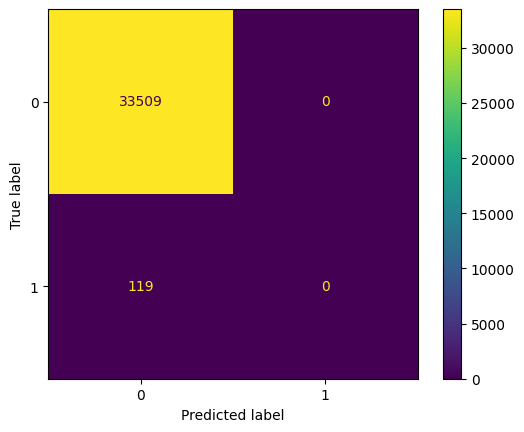

In [12]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

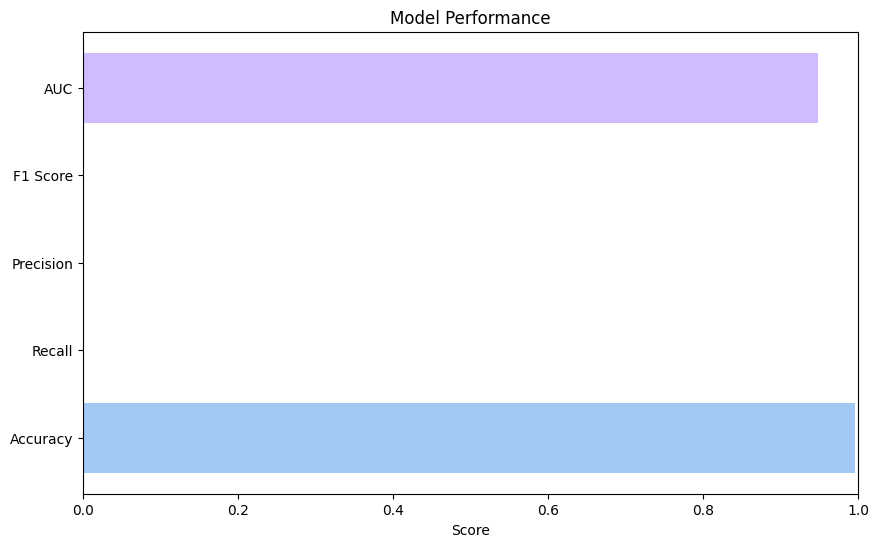

In [13]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [14]:
from sklearn.metrics import average_precision_score, auc

precision2, recall2, threshold = precision_recall_curve(y_test, y_pred_binary)
prauc = auc(precision2, recall2)
print("PRAUC: ", prauc)


PRAUC:  0.4982306411323897


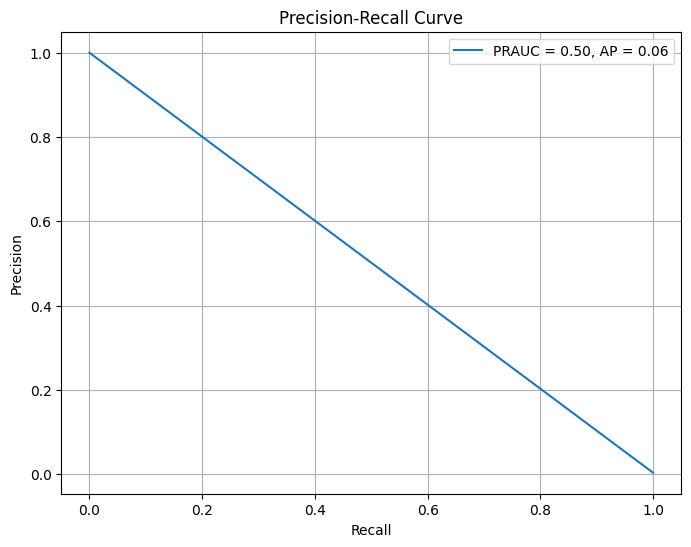

In [15]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall2, precision2, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [16]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
19          net_working_capital        3808
20                   debt_ratio        2939
21         debt_to_equity_ratio        2934
10                          m2b        2921
31     working_capital_turnover        2869
26               asset_turnover        2843
15              DTDmedianNonFin        2776
25             return_on_assets        2603
22                 equity_ratio        2563
5                liqnonfintrend        2499
6                    ni2talevel        2417
11                        sigma        2360
1                         STInt        2344
8                     sizelevel        2264
43                       macd_s        2228
41                         macd        2208
42                       macd_h        2176
4                liqnonfinlevel        2125
24            net_profit_margin        2120
38  debt_service_coverage_ratio        2074
17                  quick_ratio        2060
32            price_to_earnings 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


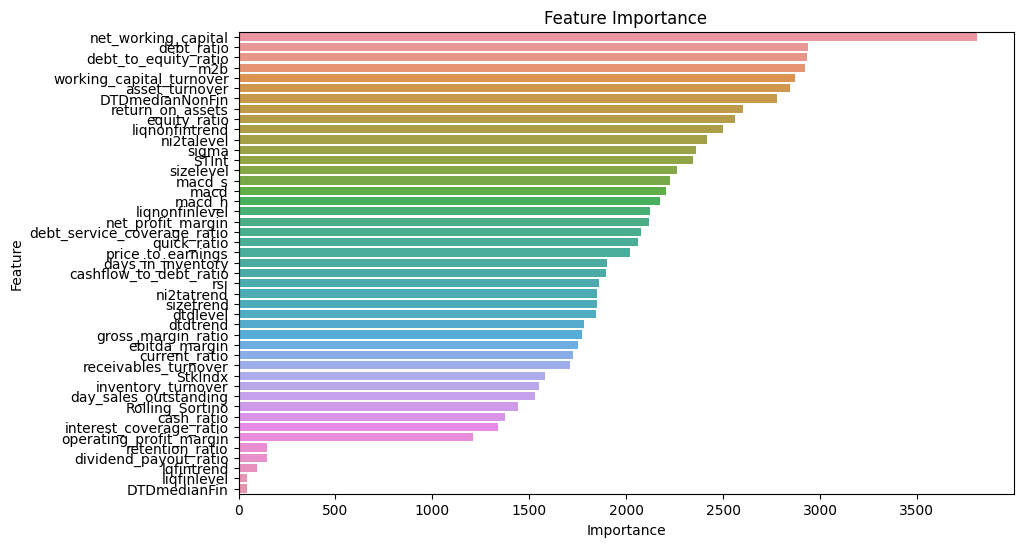

In [17]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

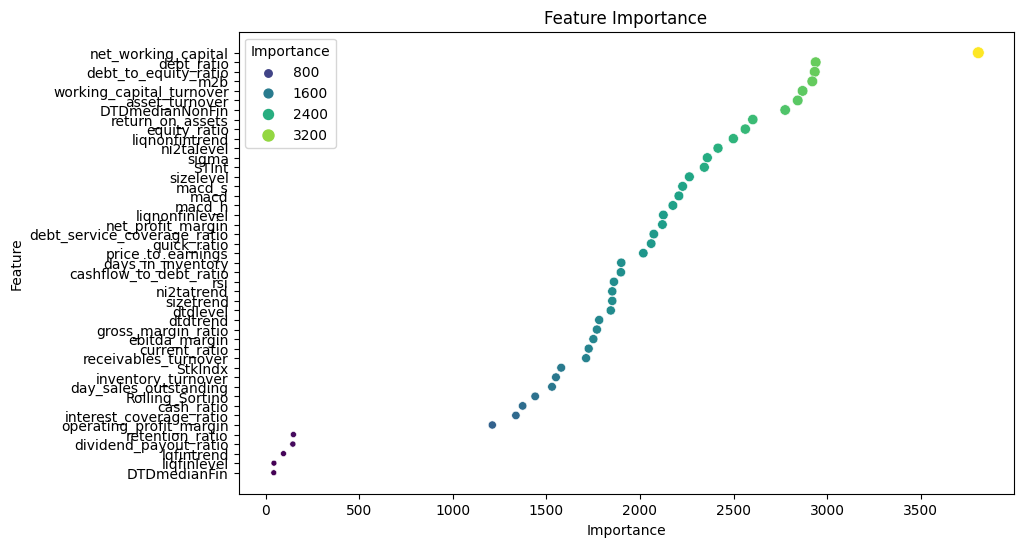

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

In [19]:
#Precision OPTIMIZED
results = pd.DataFrame({'Recall': [recall], 'Precision': [precision], 'F1 Score': [f1], 'AUC': [auc]})
results.to_csv(path + 'LGB_yfinance_results_aucoptimized.csv', index=False)

best_params_df = pd.DataFrame(best_params, index=[0])
best_params_df.to_csv(path + 'best_params_lgb_yfinance_aucoptimized.csv', index=False)

gbm.save_model(path + 'model_lgb_yfinance_aucoptimize.txt')

Load one model and Plot performances

Accuracy: 0.9964612822647794
Recall: 0.0
Precision: 0.0
F1 Score: 0.0
AUC: 0.9481072562720513


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


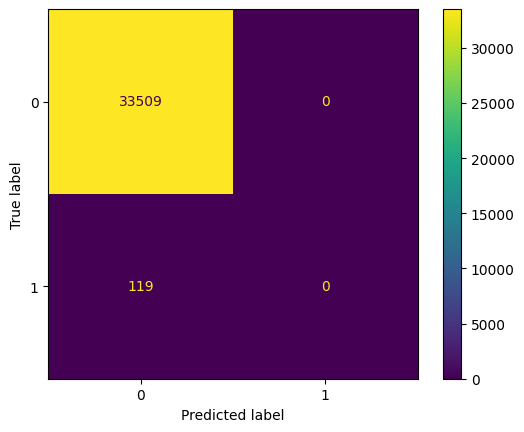

In [20]:
path_to_model = path + "model_lgb_yfinance_aucoptimize.txt"
gbm = lgb.Booster(model_file=path_to_model)

y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

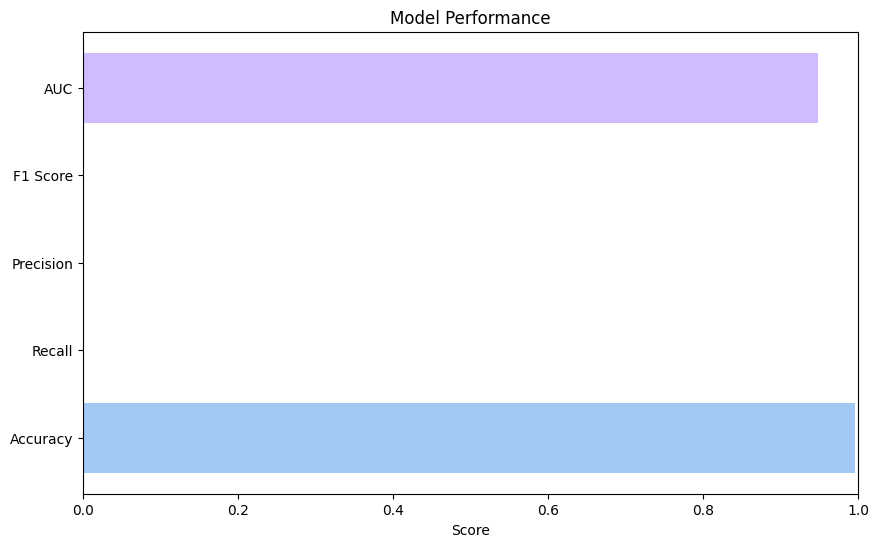

In [21]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [22]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
19          net_working_capital        3808
20                   debt_ratio        2939
21         debt_to_equity_ratio        2934
10                          m2b        2921
31     working_capital_turnover        2869
26               asset_turnover        2843
15              DTDmedianNonFin        2776
25             return_on_assets        2603
22                 equity_ratio        2563
5                liqnonfintrend        2499
6                    ni2talevel        2417
11                        sigma        2360
1                         STInt        2344
8                     sizelevel        2264
43                       macd_s        2228
41                         macd        2208
42                       macd_h        2176
4                liqnonfinlevel        2125
24            net_profit_margin        2120
38  debt_service_coverage_ratio        2074
17                  quick_ratio        2060
32            price_to_earnings 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


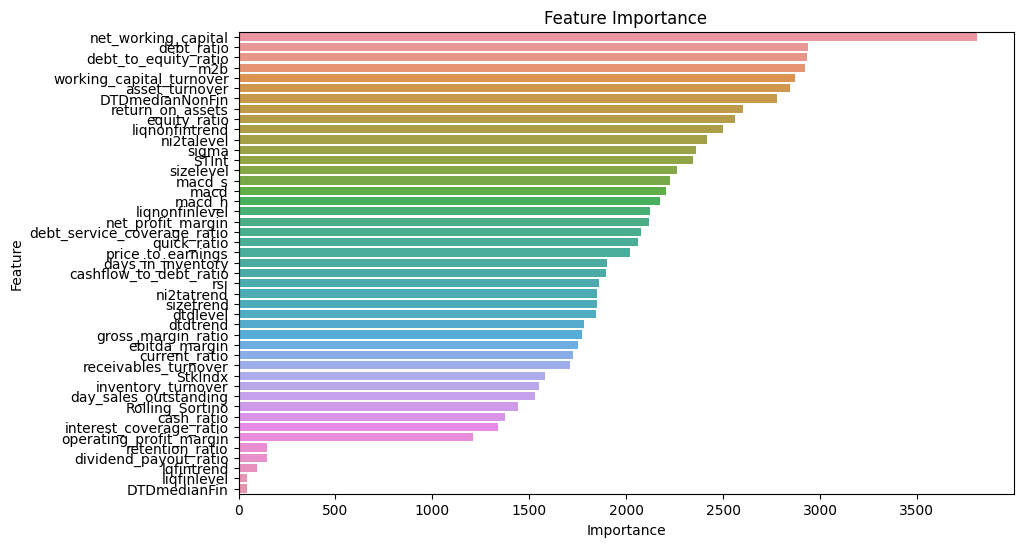

In [23]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

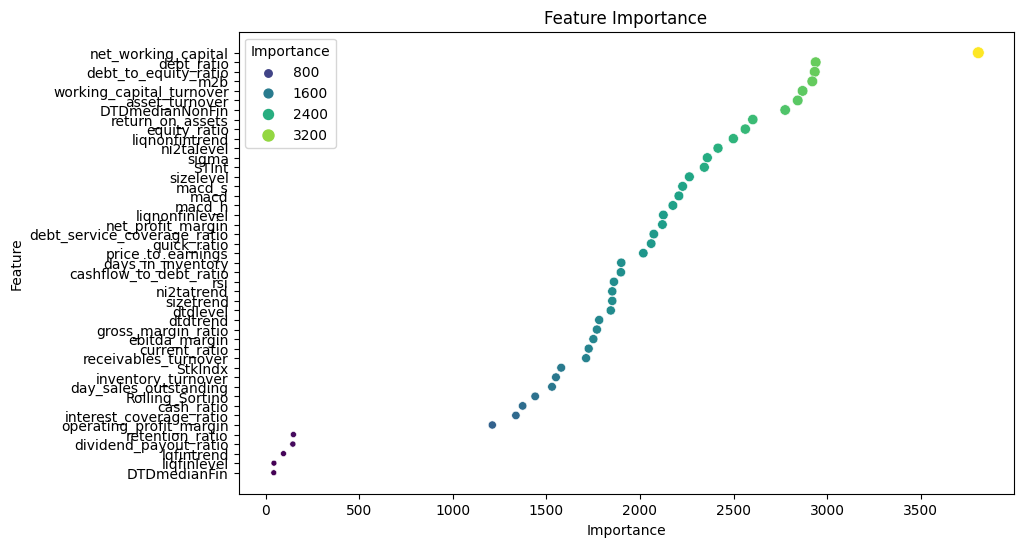

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

Load 3 models and compare performances
